In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.datasets import fetch_california_housing

In [3]:
from sklearn.preprocessing import StandardScaler

In [4]:
cali = fetch_california_housing()
df = pd.DataFrame(cali['data'], columns=cali['feature_names'])
df['target'] = cali['target']
df.tail()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847
20639,2.3886,16.0,5.254717,1.162264,1387.0,2.616981,39.37,-121.24,0.894


In [5]:
scaler = StandardScaler()
scaler.fit(df.values[:, :-1])
df.values[:, :-1] = scaler.transform(df.values[:, :-1])

In [6]:
data = torch.from_numpy(df.values).float()
X = data[:, :-1]
y = data[:, -1:]
X.shape, y.shape

(torch.Size([20640, 8]), torch.Size([20640, 1]))

In [7]:
n_epochs = 3000
batch_size = 256
print_interval = 300

In [8]:
model = nn.Sequential(
    nn.Linear(X.shape[-1], 6),
    nn.LeakyReLU(),
    nn.Linear(6, 5),
    nn.LeakyReLU(),
    nn.Linear(5, 4),
    nn.LeakyReLU(),
    nn.Linear(4, 3),
    nn.LeakyReLU(),
    nn.Linear(3, y.shape[-1])
)
optimizer = optim.Adam(model.parameters())

In [9]:
for i in range(n_epochs):
    indices = torch.randperm(X.shape[0])
    X_ = torch.index_select(X, dim=0, index=indices).split(batch_size, dim=0)
    y_ = torch.index_select(y, dim=0, index=indices).split(batch_size, dim=0)

    total_loss = 0
    y_hat = []

    for X_i, y_i in zip(X_, y_):
        y_hat_i = model(X_i)
        loss = F.mse_loss(y_hat_i, y_i)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += float(loss)
        y_hat += [y_hat_i]
    
    total_loss = total_loss / len(X_)
    if (i + 1) % print_interval == 0:
        print(f'Epoch {i + 1}: loss:{total_loss:.6f}')

Epoch 300: loss:0.334306
Epoch 600: loss:0.330676
Epoch 900: loss:0.302886
Epoch 1200: loss:0.302578
Epoch 1500: loss:0.300400
Epoch 1800: loss:0.301389
Epoch 2100: loss:0.299834
Epoch 2400: loss:0.300574
Epoch 2700: loss:0.300220
Epoch 3000: loss:0.298651


In [10]:
y_hat = torch.concat(y_hat, dim=0)
y_ = torch.concat(y_, dim=0)
X_ = torch.concat(X_, dim=0)

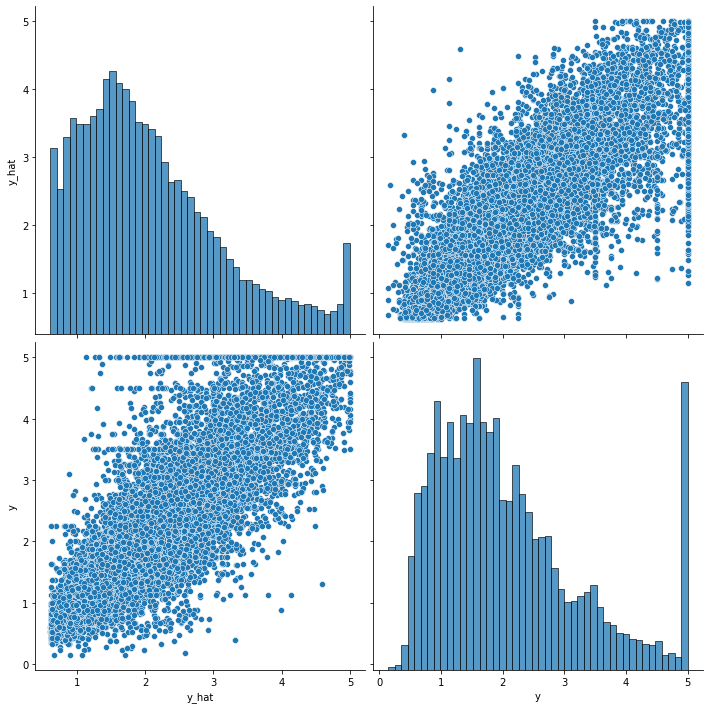

In [11]:
df = (pd.DataFrame(torch.concat([y_hat, y_], dim=1).detach().numpy(), columns=['y_hat', 'y'])
      .assign(y_hat=lambda df: df.y_hat.clip(upper=5))
)
sns.pairplot(df, height=5)
plt.show()